## ChIMES fit to all slices - A3A5A8 - SVD
### fit to 3body only data

In [1]:
import sys

import numpy as np
from src.utilities import ChIMES, parse_xyzf
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica'] + plt.rcParams['font.sans-serif']
plt.rcParams['mathtext.it'] = 'Helvetica:italic'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize']=(2, 2)
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['figure.titlesize'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2.0

chimes = ChIMES()

In [2]:
kappa = 1e-5
O3b = [2, 4, 6]
Oalpha_3b = [1, 2, 3]

r = np.linspace(48.25, 120, 200)
alpha_train = np.array([3,4,6,8])
alpha_val = np.array([5, 7])
NAME = ["A3", "A4", "A6", "A8"]


r_out = r.max()
r_in = r.min()

alpha_out = alpha_train.max()
alpha_in = alpha_train.min()

morse_lambda = 60
morse_fo = 0.75

kj2kcal = 1/4.184

### load data 

In [3]:
alpha_arr = []
pmf_arr = []
r12_arr = []
r13_arr = []
r23_arr = []
for a in alpha_train:
    pmf_data, particle_data = parse_xyzf(f"../../test_suite-lsq/OS-CG_PGNs/data/A{a}_3b_correct.xyzf", 3)
    r12_total = np.linalg.norm(particle_data[:, 1, :] - particle_data[:, 0, :], axis=1)
    r13_total = np.linalg.norm(particle_data[:, 2, :] - particle_data[:, 0, :], axis=1)
    r23_total = np.linalg.norm(particle_data[:, 2, :] - particle_data[:, 1, :], axis=1)
    
    r12_arr.append(r12_total)
    r13_arr.append(r13_total)
    r23_arr.append(r23_total)
    pmf_arr.append(pmf_data)
    alpha_arr.append(np.ones_like(r12_total) * a)       

In [4]:
pmf_arr = np.hstack(pmf_arr)
r12_arr = np.hstack(r12_arr)
r13_arr = np.hstack(r13_arr)
r23_arr = np.hstack(r23_arr)
alpha_arr = np.hstack(alpha_arr)
print(pmf_arr.shape)

(62465,)


### transformation in r_ij dim

In [5]:
chimes = ChIMES()
x, x_in, x_out = chimes.morse_trans(r12_arr, r_in, r_out, morse_lambda)
s_r12 = chimes.rescale_into_s(x, x_in, x_out)
x, x_in, x_out = chimes.morse_trans(r13_arr, r_in, r_out, morse_lambda)
s_r13 = chimes.rescale_into_s(x, x_in, x_out)
x, x_in, x_out = chimes.morse_trans(r23_arr, r_in, r_out, morse_lambda)
s_r23 = chimes.rescale_into_s(x, x_in, x_out)

s_l = chimes.rescale_into_s(alpha_arr, alpha_arr.min(), alpha_arr.max())

### tersoff smoothing fcn in r_ij dim

In [6]:
tersoff_r12 = chimes.tersoff_smooth(r12_arr, morse_fo, r_out)
tersoff_r13 = chimes.tersoff_smooth(r13_arr, morse_fo, r_out)
tersoff_r23 = chimes.tersoff_smooth(r23_arr, morse_fo, r_out)

### create matrix

Text(-0.05, 0.5, '$W^\\mathrm{OS\\text{-}CG}$ (kcal/mol)')

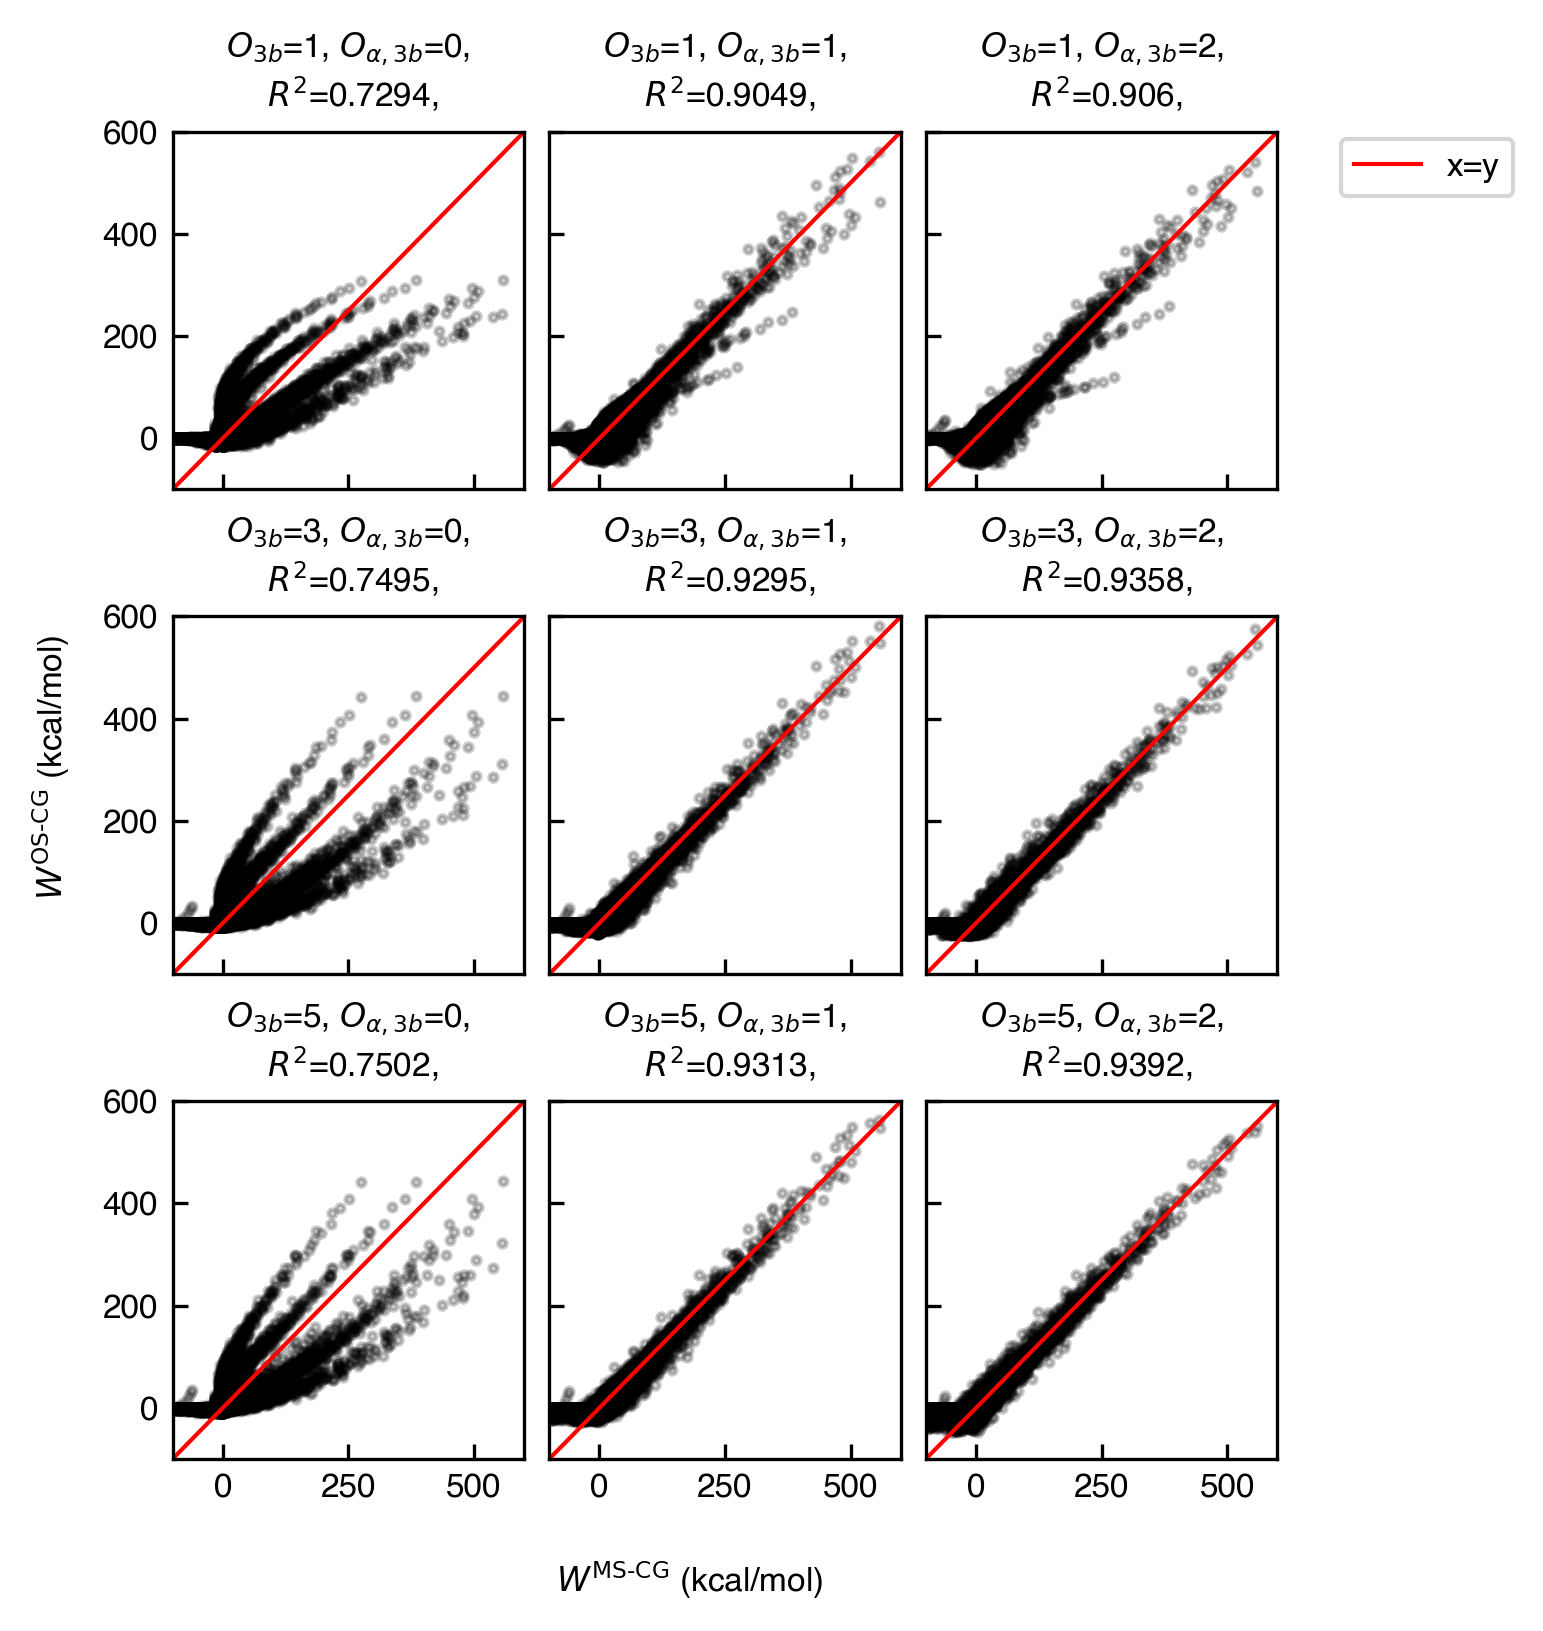

In [7]:
order_arr = []
c_arr = []
pmf_pred_arr = []
rmse_arr = []
pearson_corr_arr = []

fig, axs = plt.subplots(len(O3b), len(Oalpha_3b), figsize=(4,5), sharex=True, sharey=True, layout="constrained")
for i, order_3b in enumerate(O3b):
    for j, order_a3b in enumerate(Oalpha_3b):
        A = chimes.make_3bOnlyAmatrix_design(
            s_r12, s_r13, s_r23, s_l, 
            tersoff_r12, tersoff_r13, tersoff_r23,
            order_3b, order_a3b
        )
        c = chimes.solve_LSQ_SVD(A, pmf_arr, normal_eq=True, svd_regularization_ratio=kappa)
        pmf_pred = A @ c
        rmse = np.sqrt(np.mean((pmf_pred - pmf_arr)**2))
        pearson_correl = np.corrcoef([pmf_arr, pmf_pred])[0, 1]

        order_arr.append((order_3b, order_a3b))
        c_arr.append(c)
        pmf_pred_arr.append(pmf_pred)
        rmse_arr.append(rmse)
        pearson_corr_arr.append(pearson_correl)
        
        axs[i, j].scatter(pmf_arr*kj2kcal, pmf_pred*kj2kcal, color="k", marker="o", alpha=0.2, zorder=2)
        axs[i, j].plot([-1, 1], [-1, 1], color="r", transform=axs[i, j].transAxes, label="x=y")
                                    
        axs[i, j].set_title(
            r"$O_{3b}$" + f"={order_3b-1}, " + r"$O_{\alpha,3b}$"+f"={order_a3b-1}," + f"\n $R^{2}$={np.round(pearson_correl, 4)},"
        )
        axs[i, j].set_xlim([-100, 600.0])
        axs[i, j].set_ylim([-100, 600.0])
        axs[i, j].tick_params(axis='both', which='major', direction="in")

fig.legend(
    *axs[-1, -1].get_legend_handles_labels(), 
    bbox_to_anchor=(0.2, 0.43, 1.0, 0.5),  # (x, y, width, height)
) 

fig.text(0.5, -0.05, r'$W^\mathrm{MS\text{-}CG}$ (kcal/mol)', ha='center')
fig.text(-0.05, 0.5, r'$W^\mathrm{OS\text{-}CG}$ (kcal/mol)', va='center', rotation='vertical')

In [8]:
# save coeff in npz file for energy calcs for DA
order_idx = 4
c_3b = c_arr[order_idx]  # change to 4, 3 correct?
print(c_3b.shape)
np.savez("chimes_da_c_3b.npz", c_3b = c_3b)

(32,)


In [9]:
data = np.load("chimes_da_c_3b.npz")
test = data["c_3b"]
print(test)

[ 2.68299938e+03 -1.34277785e+02  7.08849289e+02 -8.59357166e+01
  5.28658047e+00  2.53039425e+02 -6.29048039e+03  1.06315862e+03
 -2.19824482e+03  2.04138159e+02  4.48401224e+02 -7.14444190e+02
 -2.57982332e+02  7.04464144e+01  1.46721709e+02 -1.48658410e+02
  6.64305680e+02  1.59621919e+02 -2.09632330e+02 -4.54297165e+02
  3.02263810e+02 -3.04675866e+02  1.85213489e+03 -2.06244553e+03
  1.19520778e+03  1.65237268e+03 -9.90626907e+02  7.48450638e+02
 -1.33282026e+03  7.90678295e+02 -5.31048162e+02  3.83211328e+02]


### Plot the validation slice

In [10]:
alpha_arr_val = []
pmf_arr_val = []
r12_arr_val = []
r13_arr_val = []
r23_arr_val = []
for a in alpha_val:
    pmf_data, particle_data = parse_xyzf(f"../../test_suite-lsq/OS-CG_PGNs/data/A{a}_3b_correct.xyzf", 3)
    r12_total = np.linalg.norm(particle_data[:, 1, :] - particle_data[:, 0, :], axis=1)
    r13_total = np.linalg.norm(particle_data[:, 2, :] - particle_data[:, 0, :], axis=1)
    r23_total = np.linalg.norm(particle_data[:, 2, :] - particle_data[:, 1, :], axis=1)
    
    r12_arr_val.append(r12_total)
    r13_arr_val.append(r13_total)
    r23_arr_val.append(r23_total)
    pmf_arr_val.append(pmf_data)
    alpha_arr_val.append(np.ones_like(r12_total) * a)    

In [11]:
pmf_arr_val = np.hstack(pmf_arr_val)
r12_arr_val = np.hstack(r12_arr_val)
r13_arr_val = np.hstack(r13_arr_val)
r23_arr_val = np.hstack(r23_arr_val)
alpha_arr_val = np.hstack(alpha_arr_val)

In [12]:
x, x_in, x_out = chimes.morse_trans(r12_arr_val, r_in, r_out, morse_lambda)
s_r12 = chimes.rescale_into_s(x, x_in, x_out)
x, x_in, x_out = chimes.morse_trans(r13_arr_val, r_in, r_out, morse_lambda)
s_r13 = chimes.rescale_into_s(x, x_in, x_out)
x, x_in, x_out = chimes.morse_trans(r23_arr_val, r_in, r_out, morse_lambda)
s_r23 = chimes.rescale_into_s(x, x_in, x_out)

s_a = chimes.rescale_into_s(alpha_arr_val, alpha_arr.min(), alpha_arr.max())

In [13]:
tersoff_r12 = chimes.tersoff_smooth(r12_arr_val, morse_fo, r_out)
tersoff_r13 = chimes.tersoff_smooth(r13_arr_val, morse_fo, r_out)
tersoff_r23 = chimes.tersoff_smooth(r23_arr_val, morse_fo, r_out)

In [14]:
pmf_arr_val.shape

(35188,)

Validation RMSE= 26.186352593876265
Validation R^2= 0.9712918267553848


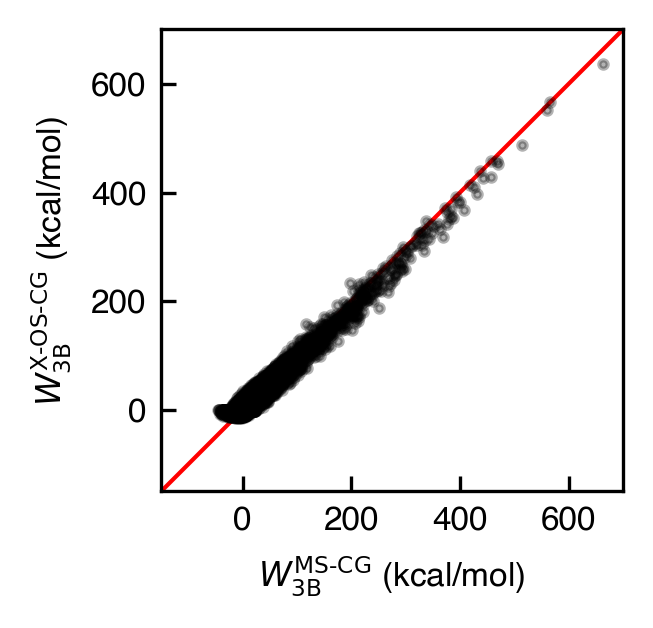

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        
A = chimes.make_3bOnlyAmatrix_design(s_r12, s_r13, s_r23, s_a, 
                         tersoff_r12, tersoff_r13, tersoff_r23,
                         order_arr[order_idx][0], order_arr[order_idx][1])
pmf_pred = A @ c_arr[order_idx]

rmse = np.sqrt(np.mean((pmf_pred - pmf_arr_val) ** 2))
pearson_correl = np.corrcoef([pmf_arr_val, pmf_pred])[0, 1]
print("Validation RMSE=", rmse)
print("Validation R^2=", pearson_correl)

ax.set_aspect('equal', 'box')
ax.plot([-1, 1], [-1, 1], color="r", transform=ax.transAxes, zorder=1)
ax.scatter(pmf_arr_val/4.184, pmf_pred/4.184, alpha=0.3, c="k", zorder=2)
ax.set_xlabel(r"$W^\mathrm{MS\text{-}CG}_\mathrm{3B}$ (kcal/mol)")
ax.set_ylabel(r"$W^\mathrm{X\text{-}OS\text{-}CG}_\mathrm{3B}$ (kcal/mol)")
ax.set_xlim([-150.0, 700.0])
ax.set_ylim([-150.0, 700.0])
ax.set_xticks([0, 200, 400 ,600], labels=[0, 200, 400 ,600])
ax.set_yticks([0, 200, 400 ,600], labels=[0, 200, 400 ,600])
ax.tick_params(axis="both", direction="in")